# Toy Model: 

$$\nabla\,\mathsf{T} = \mathrm{C}\,\mathsf{T} + \mathsf{F}$$ 

where,

$\mathsf{T} = 
\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix}$ is the vector containing sub-component temperatures,

$\mathsf{F} = 
\begin{bmatrix}
    \emptyset \\
    \mathsf{F}(t) 
\end{bmatrix}$ is the forcing function, usually assumed to be stochastic white noise for the atmospheric component. The diagonal operator $\nabla$ encodes the time-dependent factorisation of the constituent ODEs such that,

$$\nabla = 
\begin{bmatrix}
    \mathsf{m}\displaystyle\frac{\mathsf{d}}{\mathsf{d}t} & \emptyset \\
    \emptyset & \displaystyle\frac{\mathsf{d}}{\mathsf{d}t} 
\end{bmatrix},$$ 

where $\mathsf{m}$ encodes the relative temporal scale, and lastly

$$\mathrm{C} = 
\begin{bmatrix}
    \mathrm{C}_\mathsf{OO} & \mathrm{C}_\mathsf{OA} \\
    \mathrm{C}_\mathsf{AO} & \mathrm{C}_\mathsf{AA} 
\end{bmatrix}$$

is the covariance matrix. The system of equations may be written in coupled form as

$$\displaystyle\mathsf{m}\frac{\mathsf{dT_O}}{\mathsf{d}t} = \mathrm{C}_\mathsf{OO}\mathsf{T_O} + \mathrm{C}_\mathsf{OA}\mathsf{T_A},$$

$$\displaystyle\frac{\mathsf{dT_A}}{\mathsf{d}t} = \mathrm{C}_\mathsf{AO}\mathsf{T_O} + \mathrm{C}_\mathsf{AA}\mathsf{T_A} + \mathsf{F}(t).$$

In the absence of stochastic forcing. i.e. $\mathsf{F}(t) = \emptyset$, the system of coupled ODEs are easily solved using <font color='blue'>scipy.integrate.odeint()</font> to yield the time-series and the auto- and cross-correlations.


In [1]:
# environment
import matplotlib.font_manager as fm
import numpy as np
import random as rand
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
import os 
import math as mt
%matplotlib inline

cwd = os.getcwd()
pwd = os.path.abspath(os.path.join(cwd, os.pardir))
fontloc = pwd + '/Fonts/SFMono-Regular.otf'
font = fm.FontProperties(fname = fontloc,size = 8); prop = font
proplr = fm.FontProperties(fname = fontloc,size = 12)

fontlocit = pwd + '/Fonts/SFMono-RegularItalic.otf'
fontit = fm.FontProperties(fname = fontlocit,size = 8)

#ticks font
def ticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)

In [2]:
#sample initial conditions
Toi = 1.0
Tai = 1.0

# model parameters, variables and functions
tune = 0.05           #model tuning parameter
Coo = -1.08 * tune
Coa = 1.0 * tune
Cao = 0.1 * tune
Caa = -1.12 * tune
m = 10.0

# time series
t_start = 0.0
t_end = 10000.0
time_samples = 5000
resolution = (t_end - t_start)/time_samples

# DA samples
time_stable = 0.5     #ignore first <N> samples as DA stabilises; fraction of total DA steps

def autocorr(x,t):
    result = np.correlate(x, x, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def crosscorr(x,y,t):
    result = np.correlate(x, y, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def f(x,t):
    To = x[0]
    Ta = x[1]
    f0 = (1/m)*(Coo*To + Coa*Ta)
    f1 = Cao*To + Caa*Ta
    return [f0,f1]

t = np.linspace(start=t_start,stop=t_end,num=time_samples + 1)

# Variance in peak cross-correlation

In order to quantify to variance in peak cross-correlation, we run an experiment where a distribution of initial conditions is considered. 

In [3]:
import sdeint

#solve the system of ODEs with a sample set of initial conditions
samples = 200
Toi_lim = Toi      #maximum amplitude of variability in ocean
Tai_lim = Tai      #maximum amplitude of variability in atmosphere
peak_corr = []
To_l = []; Ta_l = []

# redefine unforced part
C = np.array([[(1/m)*Coo, (1/m)*Coa],
              [Cao, Caa]])

def unforc(x, t):
    return C.dot(x)

# define forcing function (weiner process with <cross-section>)
scale2 = [0.00, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.10, 0.20, 0.50, 1.00] 

def forc2(x, t):
    return W2

for j in scale2:
    crosssec2 = j * Tai
    peak_corr2 = []
    for i in range(samples):
        x0 = [rand.uniform(0.0, Toi_lim), rand.uniform(0.0, Tai_lim)]
        W2 = np.diag([0.0,crosssec2])
        soln = sdeint.itoint(unforc,forc2,x0,t)
        To_t = soln[:,0]; To_l.append(To_t)    #list with all oceanic temperatures per sample
        Ta_t = soln[:,1]; Ta_l.append(Ta_t)    #list with all atmospheric temperatures per sample
        [lag_time, crosscor] = crosscorr(Ta_t,To_t,t)
        max_index = np.argmax(crosscor)
        peak_corr2.append(abs(lag_time[max_index]))
    
    peak_corr.append(peak_corr2)

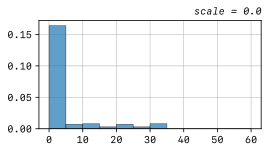

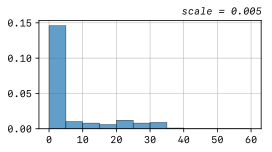

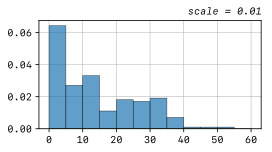

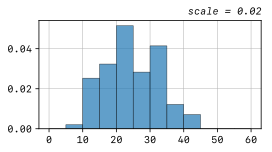

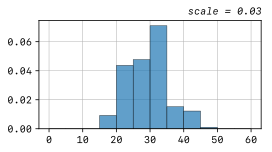

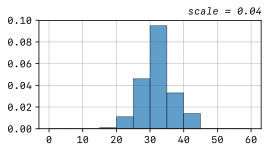

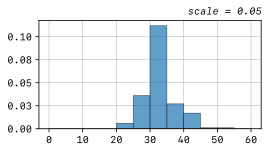

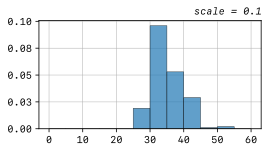

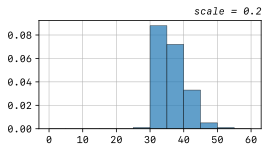

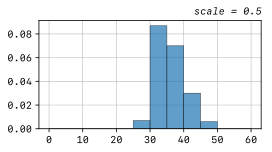

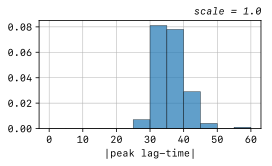

In [4]:
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter
%config InlineBackend.figure_format = 'svg'
       
#plot cross-corr statistics vs lag-times
binwidth = 5
#bins = np.arange(np.min(peak_corr), np.max(peak_corr) + binwidth, binwidth)
bins = np.arange(0, 60 + binwidth, binwidth)

for i,j in enumerate(scale2):
    fig = plt.figure(figsize=(4,2), dpi=100);
    plt.hist(np.abs(peak_corr[i]),alpha=0.7, density=True, edgecolor='black', linewidth=0.5, bins = bins)
    ax = plt.gca(); ticks(ax,10); ax.grid(linewidth=0.5);  ax.set_axisbelow(True);
    ax.set_title('scale = ' + str(j),fontproperties=fontit,fontsize=10, loc='right');
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
ax.set_xlabel('|peak lag-time|',fontproperties=font,fontsize=10);